# Optimal Portfolio Allocation

## 1

### 1.1 

Consider the min variance portfolio with a target return $m$ :

\begin{equation*}
    \arg\min_w \left(\frac{1}{2}w'\Sigma w\right) \quad \text{ s.t. } w'1 = 1, \quad \mu_\pi = w'\mu = m
\end{equation*}

First let us formulate the Lagrangian (for an optimisation problem with two constraints, hence we have two Lagrange multipliers $\lambda$ (for the returns constraint) and $\gamma$ (for the weights constraint)), and give its partial derivatives:



\begin{align*}
 L(w, \lambda, \gamma) = \frac{1}{2}w'\Sigma w + \lambda (m - w'\mu) + \gamma(1-w'1)\\
\end{align*}
Partial Derivatives (which must satisfy the first order conditions in order to minimise our objective fuction):
\begin{align*}
    \frac{\partial L}{\partial w}(w, \lambda, \gamma) &= \Sigma w - \lambda\mu -\gamma1 \hspace{10pt} ( = 0 )\\
    \frac{\partial L}{\partial \lambda}(w, \lambda, \gamma) &= m - w'\mu \hspace{10pt} ( = 0 )\\ 
    \frac{\partial L}{\partial \gamma}(w, \lambda, \gamma) &= - w'1 \hspace{10pt} ( = 0 )\\
\end{align*}

Analytical solution for $w*$ for optimal allocations: 

\begin{equation*}
w* = \Sigma^{-1}(\lambda\mu + \gamma 1)
\end{equation*}


Where $\Sigma$ is a positive definite covariance matrix, and $\lambda$, $\gamma$ are Lagrange multipliers to be found by substituting $w*$ into the two constraint equations.

We will now compute the allocations $w*$ and portfolio risk $\sigma_\pi = \sqrt{w'\Sigma w}$, for $m=4.5\%$ below : 

In [94]:
# Required imports
import numpy as np 

We will start off by defining our vectors and matrices for $\mu$, $\sigma$, $S$, $R$, $\Sigma = SRS$ and our column vector of 1s :

In [95]:
mu = np.array([[0.02],
               [0.07],
               [0.15],
               [0.20]])

sigma = np.array([[0.05],
                  [0.12],
                  [0.17],
                  [0.25]])

mat_S = np.zeros((4,4))
np.fill_diagonal(mat_S,sigma.flatten())

mat_R = np.array([[1.0, 0.3, 0.3, 0.3],
                  [0.3, 1.0, 0.6, 0.6],
                  [0.3, 0.6, 1, 0.6],
                  [0.3, 0.6, 0.6, 1]])

mat_Sigma = mat_S @ mat_R @ mat_S

mat_1s = np.array([[1.0],
                   [1.0],
                   [1.0],
                   [1.0]])

To find $w*$ we will need to work out the Lagrange multipers $\lambda$ and $\gamma$, and to do so we need to find the values of the scalar quanties A, B & C where : 

\begin{align*}
A &= 1' \Sigma^{-1}1 \\
B &= \mu' \Sigma^{-1}1 \\
C &= \mu' \Sigma^{-1} \mu \\
\end{align*}

We can then find the values for $\lambda$ and $\gamma$, where: 

\begin{align*}
\lambda &= \frac{Am - B}{AC-B^{2}} \\
\gamma &= \frac{ C - Bm}{AC-B^{2}} \\
\end{align*}

We will need to work out $\Sigma^{-1}$, the transpose the vector of 1s and the transpose of the returns vector $\mu$ in order to find A, B & C for a target return of $m = 4.5\%$:

In [96]:
mat_1s_t = np.transpose(mat_1s)
mat_Sigma_inv = np.linalg.inv(mat_Sigma)
mu_t = np.transpose(mu)
m = 0.045

In [97]:
A = mat_1s_t @ mat_Sigma_inv @ mat_1s
B = mu_t @ mat_Sigma_inv @ mat_1s
C = mu_t @ mat_Sigma_inv @ mu

In [98]:
lambda_mult = (A.item() * m - B.item()) / (A.item() * C.item() - (B.item())**2) 
gamma_mult = (C.item() - B.item() * m) / (A.item() * C.item() - (B.item())**2)

In [99]:
print(lambda_mult)
print(gamma_mult)

0.03629420298902217
0.0017774267736771414


Now $\lambda$ and $\gamma$ substituting back into the equation $w* = \Sigma^{-1}(\lambda\mu + \gamma 1)$:

In [100]:
w_star = (mat_Sigma_inv @ (lambda_mult * mu + gamma_mult * mat_1s))
print("w* (%) is:") 
print(w_star*100)

w* (%) is:
[[78.51106618]
 [ 5.38641896]
 [13.35547246]
 [ 2.7470424 ]]


Finally working out portfolio risk $\sigma_{\pi} = \sqrt{w'\Sigma w}$

In [101]:
sigma_pi = np.sqrt(np.transpose(w_star)@ mat_Sigma @ w_star)
for value in sigma_pi:
    print("Portfolio risk (%) is:", value*100)

Portfolio risk (%) is: [5.84009067]


### 1.2 

Let us start by defining the number of assets (4) that we are trying to simulate optimal allocation for, as well as creating a function to generate $> 700$ random allocation sets, where each allocation set satisfies the constraint $w'1 = 1$.

In [102]:
# Required imports
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
px.defaults.width, px.defaults.height = 1000, 600
from numpy.linalg import multi_dot
# Setting random seed at 42 for reproducability
np.random.seed(42)

In [103]:
assets = ['A', 'B', 'C', 'D']
numofassets = len(assets)
#Choosing a number of random allocation sets > 700
numofport = 5000

Calling the function port_simulation, it will return $\mu_{\pi} = w'\mu$ (port_rets) and $\sigma_\pi = \sqrt{w'\Sigma w}$ (port_vols) in a dataframe, along with the sharpe ratio :

In [104]:
def portfolio_simulation(returns:np.array, covariance:np.array) -> pd.DataFrame:

    """Function to perform portfolio simulation taking in an array of returns and a covariance matrix

    Returns:
        pd.DataFrame: Pandas DataFrame that displays portfolio returns and portfolio variance for 5000 random allocation sets
    """
    
    # Initialize empty lists
    rets=[]; vols=[]; wts=[]
    
    numofportfolio = 5000

    for i in range(numofportfolio):
        # Using random.randn() to allow for negative weights
         w1,w2,w3 = np.random.randn(3)
        # Set weights to statisfy constrain that sum of weights = 1
         w4 = 1 - (w1+w2+w3)
         weights = np.array([w1,w2,w3,w4])
         # Calculating portfolio returns and portfolio volatility
         rets.append(np.dot(weights.T,np.array(returns)))
         vols.append(np.sqrt(multi_dot([weights.T,covariance, weights])))
         wts.append(weights)
        
    # Create dataframe for portfolio stats including sharpe ratios
    data = {'port_rets': rets, 'port_vols': vols}
    for counter, symbol in enumerate(returns.tolist()):
        data[str(symbol)+' weight'] = [w[counter] for w in wts]
        
    port_df = pd.DataFrame(data)
    port_df['sharpe_ratio'] = port_df['port_rets'] / port_df['port_vols']
    
    return round(port_df,4)
    

Calling our function on the vector of returns $\mu$ and the covariance matrix $\Sigma$ : 

In [105]:
df = portfolio_simulation(mu, mat_Sigma)
# Inspecting first 5 rows
df.head()


,port_rets,port_vols,[0.02] weight,[0.07] weight,[0.15] weight,[0.2] weight,sharpe_ratio
0,[0.09618138470519748],0.1097,0.4967,-0.1383,0.6477,-0.0061,[0.8771274994468456]
1,[-0.03199858759195187],0.0842,1.5230,-0.2342,-0.2341,-0.0547,[-0.38003323911604714]
2,[-0.160551102284461],0.2175,1.5792,0.7674,-0.4695,-0.8772,[-0.7380919714659102]
3,[0.1858699798986593],0.2880,0.5426,-0.4634,-0.4657,1.3866,[0.6454524124057639]
4,[0.4914191145492791],0.8615,0.2420,-1.9133,-1.7249,4.3962,[0.5704136299957069]


Plotting expected portfolio returns $\mu_{\pi}$ on $y$ axis against expected portfolio volatility $\sigma_{\pi}$ on $x$ axis :

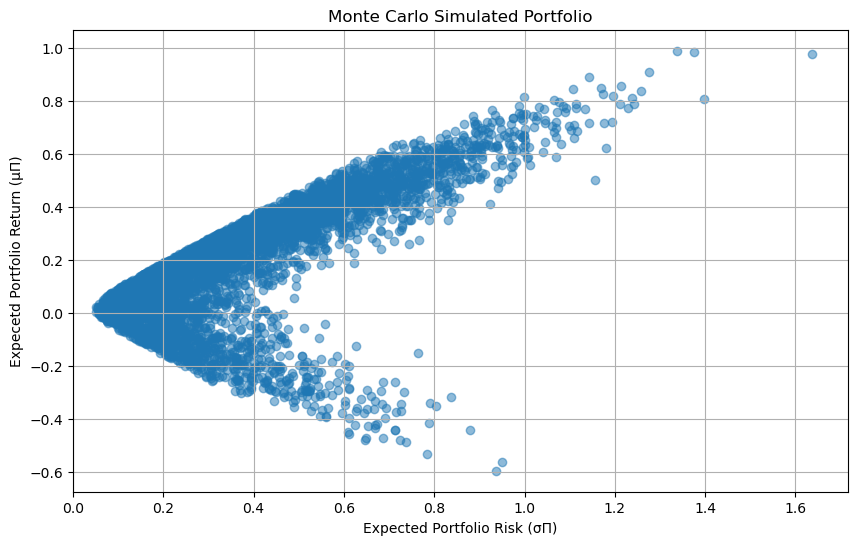

In [106]:
plt.figure(figsize=(10, 6))
plt.scatter(df['port_vols'], df['port_rets'], alpha=0.5)
plt.xlabel('Expected Portfolio Risk (σΠ)')
plt.ylabel('Expecetd Portfolio Return (μΠ)')
plt.title('Monte Carlo Simulated Portfolio')
plt.grid(True)
plt.xlim(left=0)
plt.show()

The shape of the graph roughly follows that of the efficient frontier, and we can see that, as we increase our portfolio risk level, expected portfolio returns also increases non-linearly. The optimal risk adjusted portfolio or "Maximum Sharpe" portfolio will occur when the tangency line touches the efficient frontier curve, and is hence also referred to as the tangency portfolio. This will be the portfolio with the best "risk adjusted" returns / performance.

## 2

We want to compute $\frac{\partial VaR(w)}{\partial w_{i}} = \mu_{i} + Factor \times \frac{(\Sigma w)_{i}}{\sqrt{w'\Sigma w}}$  and $\frac{\partial ES(w)}{\partial w_{i}} = \mu_{i} - \frac{\phi (Factor)}{1-c} \times \frac{(\Sigma w)_{i}}{\sqrt{w'\Sigma w}}$

For $c = 99 \%$ 

We will start by defining returns vector for $\mu$, volatilites vector for $\sigma$, weights vector w, and the diagonlised standard deviation and correlation matricies 

In [107]:
# Required imports 
from scipy.stats import norm

In [108]:
returns = np.array([[0.0],
                    [0.0],
                    [0.0]])

vol = np.array([[0.30],
                [0.20],
                [0.15]])

mat_vol = np.zeros((3,3))
np.fill_diagonal(mat_vol,vol.flatten())
print(mat_vol)

weights = np.array([[0.50],
                    [0.20],
                    [0.30]])

weights_t = np.transpose(weights)

corr_mat = np.array([[1.0, 0.8, 0.5],
                     [0.8, 1.0, 0.3],
                     [0.5, 0.3, 1]])

[[0.3  0.   0.  ]
 [0.   0.2  0.  ]
 [0.   0.   0.15]]


Let us first calculate $\frac{(\Sigma w)_{i}}{\sqrt{w'\Sigma w}}$ :

In [109]:
# Matrix product to calculate Sigma
sigma_mat = mat_vol @ corr_mat @ mat_vol
# Calulating portfolio variance (denominator)
port_var = np.sqrt(np.dot(weights_t, np.dot(sigma_mat, weights)))
frac_1 = (sigma_mat @ weights)/port_var
print(frac_1)


[[0.29396495]
 [0.16626869]
 [0.09487377]]


Now calculating $\frac{\partial VaR(w)}{\partial w_{i}}$ for 99% confidence level :

In [110]:
# Taking absolute value of inverse normal to look at the right hand tail (positive loss)
confidence_level = 0.99
factor = np.abs(norm.ppf(1-confidence_level))
print(factor)
var_sense = returns + factor * frac_1
print(var_sense)

2.3263478740408408
[[0.68386475]
 [0.38679881]
 [0.2207094 ]]


For ES sensitivity, we will reuse $\frac{(\Sigma)_{i}}{\sqrt{w'\Sigma w}}$ but we now need to work out $\frac{\phi (Factor)}{1-c}$ as well :

In [111]:
phi_factor = np.abs(norm.pdf(factor))  # abs does not make a difference here since pdf is symmetric 
print(phi_factor)
frac_2 = phi_factor/(1-confidence_level)
print(frac_2)

0.02665214220345808
2.665214220345806


Now calculating $\frac{\partial ES(w)}{\partial w_{i}}$ for the same confidence level:

In [112]:
es_sense = returns - frac_2 * frac_1
print(es_sense)

[[-0.78347958]
 [-0.44314167]
 [-0.25285893]]


Creating summary table with the computed results for VaR and ES sensitivities with regard to each asset:

In [113]:
from tabulate import tabulate

table_data = []
for i in range(len(var_sense)):
    asset = f"Asset {i+1}"
    var = f"{var_sense[i][0]:.5f}"
    es = f"{es_sense[i][0]:.5f}"
    table_data.append([asset, var, es])

# Print the table using tabulate
headers = ['Asset', '∂VaR/∂wi', '∂ES/∂wi']
print(tabulate(table_data, headers=headers, tablefmt='pretty'))


+---------+----------+----------+
|  Asset  | ∂VaR/∂wi | ∂ES/∂wi  |
+---------+----------+----------+
| Asset 1 | 0.68386  | -0.78348 |
| Asset 2 | 0.38680  | -0.44314 |
| Asset 3 | 0.22071  | -0.25286 |
+---------+----------+----------+


From the above table, we can infer that increasing the weight of asset 1 would have the biggest increase in the VaR of a portfolio, given it has the highest VaR sensitivity, with increasing the weight of asset 3 having the least impact on the VaR of a portfolio of these 3 assets. From the formula for ES sensivity, we can see the output will always be negative (as $\mu_{i} = 0$ and since $\frac{\phi (Factor)}{1-c}$ is positive), but we can interpret this as asset 1 having the greatest impact on ES, given that increasing allocation to asset 1 will have the greatest absolute impact on the ES of the portfolio. This is expected since asset 1 also has the biggest impact on VaR.

# Products and Market Risk

## 3

We will implement multi-step binomial method for a European call option with strike $E = 100$, maturity $T = 1$, for an underlying stock $S = 100$ where interest rate $r = 0.05$ 

In [114]:
# Required imports
import numpy as np
import matplotlib.pyplot as plt 
from helper import plot_asset_path, plot_probability, plot_binomial_tree 
from numpy import *

We start of by defining a function to build a binomial option tree:

In [115]:
def binomial_option(spot: float, strike: float, rate: float, sigma: float, time: float, steps: int, output: int=0) -> np.ndarray:

    """Creating a function to build a binomial option tree for a European style call option

    Args:
        spot (int or float): spot price
        strike (int or float): strike price
        rate (float): interest rate
        sigma (float): volatility
        time (int or float): maturity/expiration time 
        steps (int): number of binomial trees
        output (int): [0: price, 1: payoff, 2: option value, 3: option delta]

    Returns:
        ndarray: Array that contains price, payoff, option value and the option delta specified by the output parameter
    """

    # params
    ts = time/steps
    u = 1+sigma*np.sqrt(ts)
    v = 1- sigma*np.sqrt(ts)
    p = 0.5+rate*np.sqrt(ts)/(2*sigma)
    df = 1/(1+rate*ts)
    # initialize arrays
    px = np.zeros((steps+1, steps+1))
    cp = np.zeros((steps+1, steps+1))
    V = np.zeros((steps+1, steps+1))
    d = np.zeros((steps+1, steps+1))
    # binomial loop
    # forward loop
    for j in range(steps+1):
        for i in range(j+1):
           px[i,j] = spot*np.power(v,i)*np.power(u,j-i)
           cp[i,j] = np.maximum(px[i,j]-strike, 0)
   # reverse loop
    for j in range(steps+1, 0, -1):
        for i in range(j):
            if (j == steps+1):
                V[i,j-1] = cp[i,j-1]
                d[i,j-1] = 0
            else:
                V[i,j-1] = df * (p * V[i,j] + (1 - p) * V[i+1,j])
                d[i,j-1] = (V[i,j] - V[i+1,j]) / (px[i,j] - px[i+1,j])

    
    results = np.around(px,2) , np.around(cp,2), np.around(V,2), np.around(d,4)

    return results[output]



Now, we definie a second function to allow for a range of option values to be passed into the first function, in order to compute option value for a range of volatilities :

In [116]:
def option_volatility_range(spot:float, strike:float, rate:float, volatilities:np.array, time:float, steps:int) -> list:
    """Function to allow for a range of volatilies to be passed into the binomial_option function

    Args:
        spot (int or float): spot price
        strike (int or float): strike price
        rate (float): interest rate
        volatilities (np.array): array of volatilies between 0.05 and 0.80
        time (int or float): maturity/expiration time 
        steps (int): number of binomial trees

    Returns:
        list: a list of option values 
    """
    option_values = []
    for sigma in volatilities:
        option_value = binomial_option(spot, strike, rate, sigma, time, steps, 2)  # output = 2 because we want option price (V)
        option_values.append(option_value[0,0]) # selecting 1st element to get P.V of option for each level of volatility
    return option_values

Defining the range of volatilites, and then calling the function using the range of volatilities :

In [117]:
volatilities = np.linspace(0.05, 0.80, 75)
option_vals  = option_volatility_range(100, 100, 0.05, volatilities, 1, 4)

Plotting the results with volatility on the $x$ axis and option value on $y$ axis :

Text(0.5, 1.0, 'Plot 1: Option Value against Implied Volatility')

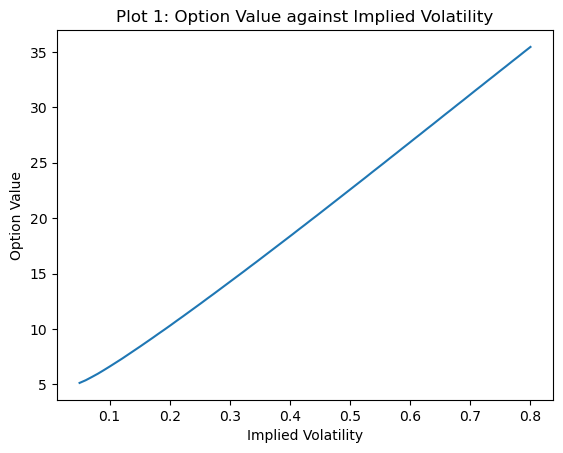

In [118]:
plt.plot(volatilities, option_vals)
plt.xlabel('Implied Volatility')
plt.ylabel('Option Value')
plt.title('Plot 1: Option Value against Implied Volatility')

This plot essentially shows the how the value of an options contract changes as implied volatility increases, and as expected, the value increases with an increase in implied volatility.

Now we want to repeat a similar process to above, but this time instead fixing $\sigma_{imp} = 0.2$ and plotting how the value of an option changes as we increase the number of time steps. We will start by defining a third function to allow for a range of different timesteps to be passed into our first function :

In [119]:
def fixed_volatility(spot:float, strike:float, rate:float, sigma: float, time:float, step_range:np.array) -> list:
    """Function to allow for a range of timesteps to be passed into the binomial_option function

    Args:
        spot (int or float): spot price
        strike (int or float): strike price
        rate (float): interest rate
        sigma (float): volatility
        time (int or float): maturity/expiration time 
        steps (np.array): array of the number of binomial trees between 4 and 50

    Returns:
        list: a list of the values of one option for different timesteps
    """
    option_values = []
    for step in step_range:
        option_value = binomial_option(spot, strike, rate, sigma, time, int(step), 2)
        option_values.append(option_value[0,0])
    return option_values
    

Defining the range of timesteps, and then calling the function using the range of timesteps :

In [120]:
step_range = np.linspace(4, 50, 46)
option_vals_fix  = fixed_volatility(100, 100, 0.05, 0.2, 1, step_range)

Plotting the results with number of timesteps on the $x$ axis and option value on the $y$ axis :

Text(0.5, 1.0, 'Plot 2: Option Value as NTS Increases')

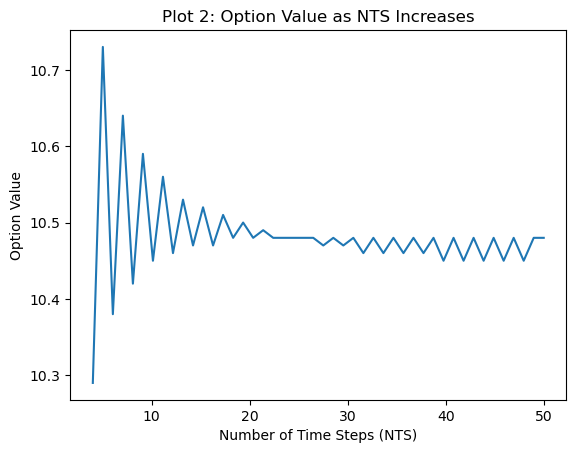

In [121]:
plt.plot(step_range, option_vals_fix)
plt.xlabel('Number of Time Steps (NTS)')
plt.ylabel('Option Value')
plt.title('Plot 2: Option Value as NTS Increases')

This plot shows us the time decay of the value of an option as the number of timesteps increases. From our plot, we can see the decay of the option value and the covergence of the price at just below 10.5, but the subsequent increase in value after around 27 timesteps, which could indicate that this is the rough number of timesteps needed to find the value of a European style call option in our case above.

## 4

### 4.1

Let us begin with the definition of Expected Shortfall as a conditional expectation: 

We can consider Expected Shortfall (ES) to be the average VaR on the tail, so it is conditional on us already being in the tail. Hence: 

\begin{align*}
    ES_{c}(X) &= \mathbb{E}[X | X \leq \text{VaR}_c(X)]
\end{align*}

where $\text{VaR}_c(X) = \mu +  \Phi^{-1}(1-c) \times \sigma$ 

Since (ES) is an average loss (conditional on being in tail) we need to average over all VaR tail percentile values to find this, which involves integrating our VaR function and then dividing by $1-c$ (our confidence level) to find average expected loss over the tail: 

\begin{align*}
    ES(X)_{c} &= \begin{aligned}
                   & \frac{1}{1-c} \int_{c}^{1} \text{VaR}_u(X) \, du && \text{(changing to upper percentiles)}
                 \end{aligned} \\
               &= \frac{1}{1-c} \int_{c}^{1} ( \mu + \Phi^{-1}(1- \mu) \sigma ) \, du \\
               &= \frac{\mu}{1-c} \int_{c}^{1} \, du + \frac{1}{1-c} \int_{c}^{1} \sigma \Phi^{-1}(1-u) \, du \hspace{8pt} \text{(using the linerarity of integrals)} \\
               &= \mu + \begin{aligned}
                          & \frac{1}{1-c} \int_{c}^{1} \sigma \Phi^{-1} (1 - u) \, du  && (\frac{1}{1-c} \hspace{5pt} \text{cancels with result of first integral when we evaluate over $[1,c]$})
                       \end{aligned}
\end{align*}

Now let $u = \Phi_{Z}(z)$ in order to cancel out the $\Phi^{-1}$. Hence, $du = \phi(z) dz$ (since the derivative of the cdf $\Phi$ = pdf $\phi$) and now the limits of integration become $[\Phi^{-1}(c), \infty]$ (since $\Phi^{-1}(1) = \infty$). 
With this substitution for u, we now have:

\begin{align*}
    &= \mu + \frac{1}{1-c} \int_{\Phi^{-1}(c)}^{\infty} \sigma \Phi^{-1} (1-\Phi_{Z}) \phi_{z} \, dz \\
    &= \mu - \frac{1}{1-c} \int_{\Phi^{-1}(c)}^{\infty} \sigma z \phi_{z} \, dz \quad (*) \quad \text{(since $1 - \Phi_{Z} = \Phi_{-Z}$; then $\Phi^{-1}(\Phi_{-Z}) = -z$)} \\
    &= \frac{1}{\sqrt{2\pi}} \int ze^{-z^{2}/2} \, dz = -e^{-z^{2}/2} \times \frac{1}{\sqrt{2\pi}} \quad \text{(by expanding the Normal pdf $\phi(z)$; $\hspace{3pt}$ also recognize that $ze^{-z^{2}/2}$ is the derivative of $-e^{-z^{2}/2}$)} \\
    &= \mu - \sigma \frac{1}{1-c}[-e^{-\infty^{2}/2} - (-e^{-[\Phi^{-1}(c)]^{2} / 2})] \times \frac{1}{\sqrt{2 \pi}} \quad \text{(by substituting above result into (*), taking $\sigma$ out of integral and evaluating integral over limits)} \\
    &= \mu - \sigma \frac{1}{1-c}[\frac{1}{\sqrt{2 \pi}}e^{-[\Phi^{-1}(c)]^{2} / 2}] \quad \text{(since $-e^{-\infty^{2}/2}$ goes to $0$)} \\
    &= \mu - \sigma \frac{\phi(\Phi^{-1}(c))}{1-c} = \mu - \sigma \frac{\phi(\Phi^{-1}(1-c))}{1-c} \quad \text{(since $\phi(\Phi^{-1}(c)) = \phi(\Phi^{-1}(1-c))$ due to symmetry of Normal Distribution)}
\end{align*}


Where we have $\phi(\Phi^{-1}(c)) = \frac{1}{\sqrt{2 \pi}} e^{-[\Phi^{-1}(c)]^{2} / 2}$ \
Hence, we now have the ES formula for the Normal Distribution


### 4.2

Let us compute the standardised value of Expected Shortfall for the range of percentiles [99.95; 99.75; 99.5; 99.25; 99; 98.5; 98; 97.5]. Since this is for the standard normal distribution, let us start off by defining $\mu$ and $\sigma$ : 

In [122]:
# Required imports 
import numpy as np
from scipy.stats import norm 
from tabulate import tabulate

In [123]:
norm_mu = 0.0
norm_sigma = 1.0
percentiles = [99.95, 99.75, 99.5, 99.25, 99.0, 98.5, 98.0, 97.5]

Defining a function to calculate ES, and formatting the output as a table:

In [124]:
def calc_es(mu:float, sigma:float, percs:list) -> str:
    """function to calculate the expected shortfall for a given range of percentiles

    Args:
        mu (int): mean of standard normal distribution
        sigma (int): standard deviation of standard normal distribution
        percs (list): list of given percentiles we want to iterate over

    Returns:
        str: table of expected shortfall values that correspond to percentiles from input list
    """
    results = []

    for c in percs:
        z = norm.ppf(1.0-c / 100.0)
        es = mu - sigma * norm.pdf(z) / (1.0 - c / 100.0)
        results.append(es)
    
    # Creating a table
    table = []
    for i, c in enumerate(percentiles):
        table.append([f"{c}%", results[i]])
    
    return print(tabulate(table, headers=["Percentile", "ES"], tablefmt="pretty"))

es_table = calc_es(norm_mu, norm_sigma, percentiles)
es_table

+------------+---------------------+
| Percentile |         ES          |
+------------+---------------------+
|   99.95%   | -3.5543806938542857 |
|   99.75%   | -3.104357363203606  |
|   99.5%    | -2.8919486053834813 |
|   99.25%   | -2.761239803172472  |
|   99.0%    | -2.665214220345806  |
|   98.5%    | -2.5246953986002407 |
|   98.0%    | -2.4209067940371014 |
|   97.5%    | -2.3378027922014133 |
+------------+---------------------+


We can see from the table above that, the higher the percentile, the greater the magnitude of the expected shortfall, so the more we can expected to lose on average, given the VaR threshold has already been breached

## 5

We will start off by importing in the required SP500 data from the csv provided, and then formatting this as a dataframe and inspecting the first 5 elements of the dataframe

In [125]:
# Required imports 
import pandas as pd
import numpy as np 
from scipy.stats import norm 
import matplotlib.pyplot as plt 

In [126]:
data = pd.read_csv('sp500_data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.head()

,Date,SP500
0,2013-01-22,1492.560059
1,2013-01-23,1494.810059
2,2013-01-24,1494.819946
3,2013-01-25,1502.959961
4,2013-01-28,1500.180054


Adding an extra column with the daily logged returns: 

In [127]:
# Calculating the daily log percentage returns
data['Daily Return (Log %)'] = np.log1p(data['SP500'].pct_change()) * 100
data

,Date,SP500,Daily Return (Log %)
0,2013-01-22,1492.560059,NaN
1,2013-01-23,1494.810059,0.150634
2,2013-01-24,1494.819946,0.000661
3,2013-01-25,1502.959961,0.543071
4,2013-01-28,1500.180054,-0.185133
...,...,...,...
1245,2017-12-29,2673.610107,-0.519663
1246,2018-01-02,2695.810059,0.826908
1247,2018-01-03,2713.060059,0.637843
1248,2018-01-04,2723.989990,0.402054


Defining the 99% confidence interval and normal factor, and working out the count and percentage of VaR breaches for 10 day VaR, where $VaR_{10D,t} = Factor \times \sigma_{t} \times \sqrt{10}$ , as well as defining a breach of VaR as: \
$r_{10D,t+10} < VaR_{10D,t}$ :

In [128]:
conf_level = 0.99
stand_var = norm.ppf(1-conf_level)

# Working out 10D predicted VaR over using standard deviation over a 21 day timeframe to get good estimate for volatility
data['10D/99% VaR - Pred (%)'] = data['Daily Return (Log %)'].rolling(window=21).std()*np.sqrt(10)*stand_var
# Working out 10D forward real returns
data['10D Fwd Ret - Real (%)'] = (np.log((data['SP500'].shift(-11)) / data['SP500'].shift(-1))*100).dropna()
# Working out Var breaches where 10D forward real returns < 10D predicted VaR
data['Var Breach'] = np.where(data['10D Fwd Ret - Real (%)'].notna() & (data['10D Fwd Ret - Real (%)'] < data['10D/99% VaR - Pred (%)']), 1, 0)

num_breaches = data['Var Breach'].sum()
perc_breaches = (num_breaches / len(data))*100
exp_breaches = (0.01*len(data))

In [129]:
print("Number of VaR breaches:", num_breaches)
print("Percentage of VaR breaches:", perc_breaches)
print("Number of expected VaR breaches for 99% confidence level:", int(exp_breaches))

Number of VaR breaches: 25
Percentage of VaR breaches: 2.0
Number of expected VaR breaches for 99% confidence level: 12


Now we will work out the count and the percentage of consecutive VaR breaches: 

In [130]:
consec_breach_count = np.where((data['Var Breach'] == 1) & (data['Var Breach'].shift(-1) == 1), 1, 0)
print("Number of consecutive VaR breaches:", consec_breach_count.sum())
consec_breach_perc = (consec_breach_count.sum() / len(data)) * 100
print("Percentage of consecutive VaR breaches:", round(consec_breach_perc, 3))

Number of consecutive VaR breaches: 14
Percentage of consecutive VaR breaches: 1.12


Now we will plot the 10D Fwd Ret over time, and highlight any VaR breaches with a Dot 

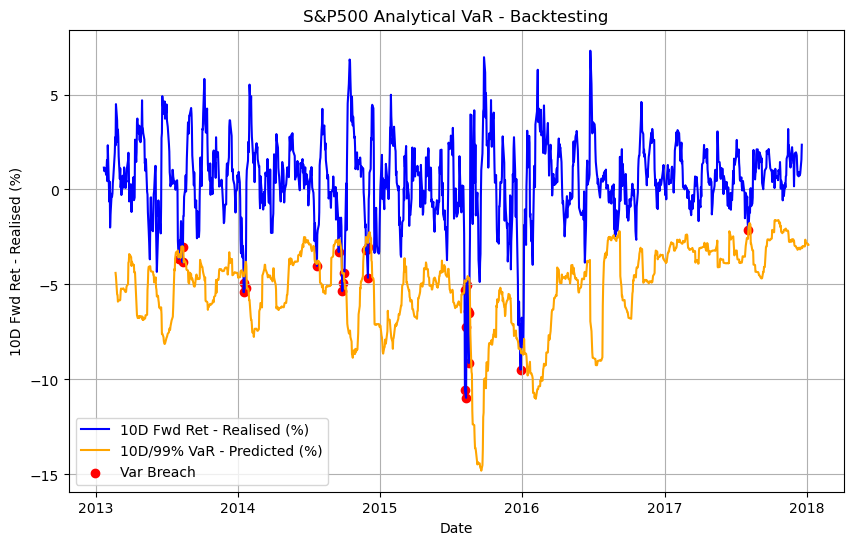

In [131]:
# Plot the '10D Fwd Ret - Real' and '10D/99% VaR - Pred' over time
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['10D Fwd Ret - Real (%)'], color='blue', label='10D Fwd Ret - Realised (%)')
plt.plot(data['Date'], data['10D/99% VaR - Pred (%)'], color='orange', label='10D/99% VaR - Predicted (%)')

# Highlight cases where 'Var Breach' has occured (is '1')
breach_dates = data[data['Var Breach'] == 1]['Date']
breach_values = data[data['Var Breach'] == 1]['10D Fwd Ret - Real (%)']
plt.scatter(breach_dates, breach_values, color='red', label='Var Breach')

# Labelling the axis and the plot 
plt.xlabel('Date')
plt.ylabel('10D Fwd Ret - Realised (%)')
plt.title('S&P500 Analytical VaR - Backtesting')
plt.legend()
plt.grid(True)
plt.show()

This plot shows us the 10 Day Forward Realised Returns as a percentage over a time period of 5 years, and we have also plotted the 10 Day Predicted VaR for the same time period, highlighting in red any time the real returns breached the predicted VaR thresholds (defined in the formula above).